In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def visualize_feature_map_across_slices(
    npz_path: str, layer_key: str, max_slices: int = 16, max_channels: int = 8, cmap: str = "viridis"
):
    """
    可视化某一层在不同 slice 上的 feature map。展示前 max_slices 个 slices，每个 slice 展示前 max_channels 个 channel。

    第一列将尝试显示“原图”（若 npz 内可自动识别到原图键），否则回退为显示 ch=0 的特征图。
    注意：网络的 feature 各通道通常无固定语义，因此 ch=0 不是原图；若需原图，请确保 npz 中包含原图键。
    """
    feat_file = np.load(npz_path)
    if layer_key not in feat_file:
        raise KeyError(f"{layer_key} not in {list(feat_file.keys())}")
    arr = feat_file[layer_key]

    # 尝试从同一 npz 中自动识别原图
    orig = None
    orig_key = None
    candidate_keys = (
        "image", "images", "input", "inputs", "raw", "orig", "original", "source", "img", "image0", "data"
    )
    for k in candidate_keys:
        if k in feat_file:
            orig = feat_file[k]
            orig_key = k
            break

    def get_orig_slice(y: int, num_slices_expected: int):
        if orig is None:
            return None
        # 常见形状：
        # - 3D: (Z, H, W)
        # - 4D: (C, Z, H, W) 或 (Z, C, H, W)
        try:
            if orig.ndim == 3:
                # 假设 (Z, H, W)
                if orig.shape[0] >= y + 1:
                    return orig[y]
                return None
            if orig.ndim == 4:
                if orig.shape[0] <= 4 and orig.shape[1] >= y + 1:
                    # (C, Z, H, W) 取第0通道
                    return orig[0, y]
                if orig.shape[0] >= y + 1:
                    # (Z, C, H, W) 取第0通道
                    c_axis = 1
                    c0 = 0 if orig.shape[c_axis] > 0 else None
                    if c0 is None:
                        return None
                    return orig[y, c0]
        except Exception:
            return None
        return None

    def minmax(img):
        img = np.asarray(img)
        if img.ndim != 2:
            return img
        vmin = float(np.min(img))
        vmax = float(np.max(img))
        if vmax > vmin:
            return (img - vmin) / (vmax - vmin + 1e-8)
        return img

    if arr.ndim == 4:
        # (C, Z, H, W) or (Z, C, H, W)
        shape = arr.shape
        if shape[0] <= 32 and shape[1] > 8:
            # Assume (C, Z, H, W)
            ch_axis, z_axis = 0, 1
        else:
            # Assume (Z, C, H, W)
            z_axis, ch_axis = 0, 1
        num_slices = arr.shape[z_axis]
        num_channels = arr.shape[ch_axis]

        n_slices_show = min(num_slices, max_slices)
        n_channels_show = min(num_channels, max_channels)

        # 第一行、第一列预留出来显示slice=0或原图
        fig, axes = plt.subplots(
            n_slices_show + 1, n_channels_show + 1,
            figsize=((n_channels_show + 1) * 4, (n_slices_show + 1) * 4)
        )

        # 填第一行（slice=0, ch不同）
        for x in range(n_channels_show):
            if shape[0] <= 32:
                img = arr[x, 0]  # ch=x, slice=0
            else:
                img = arr[0, x]   # slice=0, ch=x
            ax = axes[0, x + 1]
            ax.imshow(img, cmap=cmap)
            ax.set_title(f"Slice 0, Ch {x}")
            ax.axis("off")

        # 填第一列（原图，若无则回退到 ch=0）
        for y in range(n_slices_show):
            img0 = get_orig_slice(y, num_slices_expected=num_slices)
            ax = axes[y + 1, 0]
            if img0 is None:
                # 回退
                if shape[0] <= 32:
                    img0 = arr[0, y]  # ch=0, slice=y
                else:
                    img0 = arr[y, 0]  # slice=y, ch=0
                ax.set_title(f"Slice {y}, Ch 0")
                ax.imshow(minmax(img0), cmap="gray")
            else:
                title_suffix = f" ({orig_key})" if orig_key else ""
                ax.set_title(f"Slice {y}, Orig{title_suffix}")
                ax.imshow(minmax(img0), cmap="gray")
            ax.axis("off")

        # 填主区域（slice, ch均不为0）
        for y in range(n_slices_show):
            for x in range(n_channels_show):
                if shape[0] <= 32:
                    img = arr[x, y]
                else:
                    img = arr[y, x]
                ax = axes[y + 1, x + 1]
                ax.imshow(img, cmap=cmap)
                ax.set_title(f"Slice {y}, Ch {x}")
                ax.axis("off")

        # 左上角空白
        axes[0, 0].axis("off")
        axes[0, 0].set_title("")
        # 显式标注
        axes[0, 0].text(0.5, 0.5, "（第一列为原图，如未找到则为ch=0）", ha='center', va='center', fontsize=16, color="red")

        plt.tight_layout()
        plt.show()

    elif arr.ndim == 3:
        print(f"Layer {layer_key} does not have a slice axis, only {arr.shape}")
    else:
        print(f"Unsupported feature shape {arr.shape} for layer {layer_key}")



# Feature extraction via Pretrained nnunet

nnunet could be quite complicated, which is also not available for out-of-box feature extraction.

In [2]:
# results folder
import os 
import numpy as np

results_folder = '/data/Projects/cmr_reverse/results/stone/'
# npz files
npz_files = [f for f in os.listdir(results_folder) if f.endswith('.npz')]

In [3]:
npz_files[0]

'0001_3_features.npz'

In [4]:
feature_frame01 = np.load(os.path.join(results_folder, npz_files[0]))



In [5]:
import matplotlib.pyplot as plt
for key in feature_frame01.keys():
    print(key)
    #plt.imshow(feature_frame01[key][0, 0])

logits_final
dec_stage0
dec_stage1
dec_stage2
dec_stage3
dec_stage4
dec_stage5
enc_stage0
enc_stage1
enc_stage2
enc_stage3
enc_stage4
enc_stage5
logits_stage0
logits_stage1
logits_stage2
logits_stage3
logits_stage4
logits_stage5


In [6]:
feature_frame01['enc_stage0'].shape

(32, 11, 320, 320)

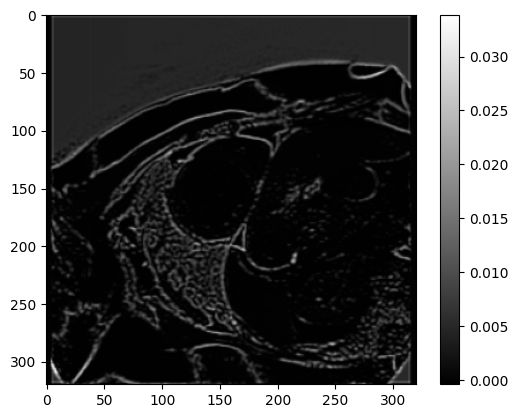

In [7]:
plt.imshow(feature_frame01['enc_stage0'][7,7], cmap='gray')
plt.colorbar()

In [8]:
# helper functions for loading raw images, seg masks and matching feature files to stone dataset frames
import math

raw_root = "/data/Data/nnunetdata/raw/nnUNet_raw_data/stone"
results_root = results_folder  # reuse from above

# try nibabel first; fall back to SimpleITK if needed
try:
    import nibabel as nib
    _use_nib = True
except ImportError:
    import SimpleITK as sitk
    _use_nib = False


def get_case_id_from_npz(npz_name: str) -> str:
    """"0001_0_features.npz" -> "0001_0"""  # noqa: D401
    base = os.path.basename(npz_name)
    if base.endswith("_features.npz"):
        return base[:-len("_features.npz")]
    return os.path.splitext(base)[0]


def get_raw_path_for_npz(npz_name: str) -> str:
    case_id = get_case_id_from_npz(npz_name)
    raw_path = os.path.join(raw_root, f"{case_id}_0000.nii.gz")
    return raw_path


def get_seg_path_for_npz(npz_name: str) -> str:
    """map *_features.npz -> corresponding prediction mask in results (e.g. 0001_0.nii.gz)."""
    case_id = get_case_id_from_npz(npz_name)
    seg_path = os.path.join(results_root, f"{case_id}.nii.gz")
    return seg_path


def load_raw_image_for_npz(npz_path: str):
    """Load corresponding raw stone image for a given *_features.npz path."""
    raw_path = get_raw_path_for_npz(os.path.basename(npz_path))
    if not os.path.exists(raw_path):
        raise FileNotFoundError(raw_path)
    if _use_nib:
        img = nib.load(raw_path)
        data = img.get_fdata()
    else:
        img = sitk.ReadImage(raw_path)
        data = sitk.GetArrayFromImage(img)
    return data, img


def load_seg_for_npz(npz_path: str):
    """Load corresponding nnUNet prediction mask for a given *_features.npz path.

    返回 (seg_array, seg_img)。如果找不到 mask，则返回 (None, None)。
    """
    seg_path = get_seg_path_for_npz(os.path.basename(npz_path))
    if not os.path.exists(seg_path):
        print(f"WARNING: seg mask not found for {npz_path}: {seg_path}")
        return None, None
    if _use_nib:
        img = nib.load(seg_path)
        data = img.get_fdata()
    else:
        img = sitk.ReadImage(seg_path)
        data = sitk.GetArrayFromImage(img)
    return data, img



In [61]:
def visualize_layer_with_raw(
    npz_path: str,
    layer_key: str,
    slice_idx: int = 0,
    channel_indices=None,
    max_channels: int = 16,
    cmap: str = "gray",
    raw_list: list = None,
    npz_list: list = None,
    transpose_raw: bool = True,
    overlay_mask: bool = True,
):
    """
    Visualize multiple channels of a single layer, on the left the raw image + mask,
    then feature maps (channels) are shown in a compact grid (8-9 columns per row).
    每个subplot都没有colorbar，使整体显示更紧凑。
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import math
    import os

    # Print file names and prefix for easier alignment
    if raw_list is not None and npz_list is not None:
        npz_bases = [os.path.basename(f) for f in npz_list]
        raw_bases = [os.path.basename(f) for f in raw_list]

        def extract_prefix(fn):
            if "_features.npz" in fn:
                return fn.replace("_features.npz", "")
            if fn.endswith(".nii.gz"):
                return fn.replace("_0000.nii.gz", "")
            return os.path.splitext(fn)[0]

        npz_prefixes = [extract_prefix(f) for f in npz_bases]
        raw_prefixes = [extract_prefix(f) for f in raw_bases]
        print("npz_list:")
        for i, (b, p) in enumerate(zip(npz_bases, npz_prefixes)):
            print(f"  [{i}] {b} → {p}")
        print("raw_list:")
        for i, (b, p) in enumerate(zip(raw_bases, raw_prefixes)):
            print(f"  [{i}] {b} → {p}")
        print(f"cur npz_path: {os.path.basename(npz_path)} → {extract_prefix(os.path.basename(npz_path))}")

    # --- Feature slice ---
    feat_file = np.load(npz_path)
    if layer_key not in feat_file:
        raise KeyError(f"{layer_key} not in {list(feat_file.keys())}")
    arr = feat_file[layer_key]
    if arr.ndim == 4:
        # (C, Z, H, W)
        if slice_idx >= arr.shape[1]:
            raise ValueError(f"slice_idx {slice_idx} out of range for {layer_key} with shape {arr.shape}")
        feat_slice = arr[:, slice_idx]  # (C, H, W)
    elif arr.ndim == 3:
        feat_slice = arr
    else:
        raise ValueError(f"Unexpected feature shape {arr.shape} for {layer_key}")

    C, H, W = feat_slice.shape
    if channel_indices is None:
        channel_indices = list(range(min(C, max_channels)))
    else:
        channel_indices = [c for c in channel_indices if 0 <= c < C]
    if len(channel_indices) == 0:
        raise ValueError("No valid channels to visualize")

    # --- Raw image + seg mask ---
    raw_vol, _ = load_raw_image_for_npz(npz_path)
    seg_vol, _ = load_seg_for_npz(npz_path) if overlay_mask else (None, None)

    print(f"raw_vol.shape = {raw_vol.shape}")
    if raw_vol.ndim == 3:
        # Use the smallest dimension as the slice axis
        z_dim = int(np.argmin(raw_vol.shape))
        print(f"Assume slice dim = {z_dim}")
        if slice_idx >= raw_vol.shape[z_dim]:
            slice_idx_raw = min(slice_idx, raw_vol.shape[z_dim] - 1)
        else:
            slice_idx_raw = slice_idx
        raw_slice = np.take(raw_vol, slice_idx_raw, axis=z_dim)
        seg_slice = None
        if seg_vol is not None and seg_vol.ndim == 3:
            if seg_vol.shape == raw_vol.shape:
                seg_slice = np.take(seg_vol, slice_idx_raw, axis=z_dim)
            else:
                z_dim_seg = int(np.argmin(seg_vol.shape))
                seg_slice = np.take(seg_vol, min(slice_idx_raw, seg_vol.shape[z_dim_seg] - 1), axis=z_dim_seg)
    elif raw_vol.ndim == 2:
        raw_slice = raw_vol
        seg_slice = seg_vol if (seg_vol is not None and seg_vol.ndim == 2) else None
    else:
        raise ValueError(f"Unexpected raw image shape {raw_vol.shape}")

    # Optionally transpose the raw/seg slice for easier alignment
    if transpose_raw:
        raw_slice = raw_slice.T
        if seg_slice is not None:
            seg_slice = seg_slice.T
        print("INFO: transposed raw (and seg) for visualization.")

    # --- Size check: Transpose feature if needed to match raw ---
    H_feat, W_feat = feat_slice[0].shape
    H_raw, W_raw = raw_slice.shape
    need_transpose_feat = False
    if (H_feat, W_feat) != (H_raw, W_raw):
        if (H_feat, W_feat) == (W_raw, H_raw):
            need_transpose_feat = True
            print(f"⚠️ Detected feature H/W likely transposed: feature shape {(H_feat, W_feat)}, raw shape {(H_raw, W_raw)}. Will transpose feature for visualization.")
        else:
            print(f"⚠️ Feature (H,W) = {(H_feat, W_feat)}, raw (H,W) = {(H_raw, W_raw)}. Shapes do not match and cannot resolve by transpose. Show as is.")

    n_channels = len(channel_indices)
    n_cols = 9
    n_rows = math.ceil((n_channels + 1) / n_cols)

    # ！！放大每个subplot，保证和之前一样大（之前每行4英寸，现在每行是1.6*9=14.4，要还原大图，用每列4英寸）
    # 之前的大的figure像这样：figsize=(4*n_cols, 4*n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows), squeeze=False)

    # -- First: raw+mask
    ax = axes[0, 0]
    im = ax.imshow(raw_slice, cmap=cmap)
    ax.set_title(f"Raw+Mask (slice={slice_idx})", fontsize=10)
    ax.axis("off")
    # 不画colorbar
    # cbar = fig.colorbar(im, ax=ax, shrink=0.7, pad=0.02)
    # cbar.ax.tick_params(labelsize=8)

    if overlay_mask and seg_slice is not None:
        # Assume label: 1=RV, 2=MYO, 3=LV
        label_info = {
            1: ("RV", "red"),
            2: ("MYO", "blue"),
            3: ("LV", "green"),
        }
        from matplotlib.patches import Patch
        handles = []
        for lab, (name, color) in label_info.items():
            mask = seg_slice == lab
            if np.any(mask):
                ax.contour(mask, levels=[0.5], colors=color, linewidths=1.0)
                handles.append(Patch(facecolor="none", edgecolor=color, label=name))
        if handles:
            ax.legend(handles=handles, loc="lower right", fontsize=7, framealpha=0.7)

    # --- Feature channels ---
    plot_count = 1 # 1 already used for raw
    for idx, ch in enumerate(channel_indices):
        row = (plot_count) // n_cols
        col = (plot_count) % n_cols
        ax2 = axes[row, col]
        feat_img = feat_slice[ch]
        if need_transpose_feat:
            feat_img = feat_img.T
        # 用1st-99th百分位以避免极端异常值与统一色带
        im2 = ax2.imshow(feat_img, cmap=cmap)
        ax2.set_title(f"Ch {ch}", fontsize=9)
        ax2.axis("off")
        # 不画colorbar
        #cbar2 = fig.colorbar(im2, ax=ax2, shrink=0.7, pad=0.02)
        #cbar2.ax.tick_params(labelsize=7)
        plot_count += 1

    # Hide unused axes
    for i in range(plot_count, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].axis("off")

    plt.tight_layout(w_pad=0.15, h_pad=0.2)


In [62]:
def aggregate_feature_map(feat_3d: np.ndarray, mode: str = "l2") -> np.ndarray:
    """
    对单层特征 (C, H, W) 做 channel-wise 聚合，返回 (H, W)。
    """
    if feat_3d.ndim != 3:
        raise ValueError(f"Expected (C,H,W), got {feat_3d.shape}")
    if mode == "l2":
        return np.sqrt(np.sum(feat_3d ** 2, axis=0))
    elif mode == "mean":
        return np.mean(feat_3d, axis=0)
    elif mode == "max":
        return np.max(feat_3d, axis=0)
    elif mode == "absmean":
        return np.mean(np.abs(feat_3d), axis=0)
    elif mode == "absmax":
        return np.max(np.abs(feat_3d), axis=0)
    else:
        raise ValueError(f"Unknown aggregation mode: {mode}")


def visualize_aggregated_layers(npz_path: str,
                                layer_keys=None,
                                slice_idx: int = 0,
                                agg_mode: str = "l2",
                                cmap: str = "viridis"):
    """
    对多层做 channel-wise 聚合，每层只画一个 (H, W) map，方便快速浏览 encoder/decoder/logits。
    """
    feat_file = np.load(npz_path)

    if layer_keys is None:
        # 默认只看 encoder/decoder/logits
        layer_keys = [k for k in feat_file.keys()
                      if k.startswith("enc_stage") or k.startswith("dec_stage") or k.startswith("logits_stage")
                      or k == "logits_final"]
    layer_keys = sorted(layer_keys)

    n = len(layer_keys)
    plt.figure(figsize=(4 * n, 4))
    for i, key in enumerate(layer_keys, 1):
        arr = feat_file[key]
        if arr.ndim == 4:
            feat_slice = arr[slice_idx]  # (C,H,W)
        elif arr.ndim == 3:
            feat_slice = arr
        else:
            continue
        agg = aggregate_feature_map(feat_slice, mode=agg_mode)
        ax = plt.subplot(1, n, i)
        ax.imshow(agg, cmap=cmap)
        ax.set_title(key)
        ax.axis("off")
    plt.tight_layout()


def compute_layer_contrast_correlation(npz_files,
                                       layer_key: str,
                                       slice_idx: int = 0,
                                       agg_mode: str = "l2"):
    """
    计算某一层在不同 frame 之间的相似度（基于聚合后的 feature map 的 Pearson 相关系数）。
    npz_files 可以是文件名或绝对路径列表。
    返回相关系数矩阵 (N_frames, N_frames)。
    """
    maps = []
    for p in npz_files:
        if not os.path.isabs(p):
            p_full = os.path.join(results_root, p)
        else:
            p_full = p
        feat_file = np.load(p_full)
        if layer_key not in feat_file:
            raise KeyError(f"{layer_key} not in {list(feat_file.keys())}")
        arr = feat_file[layer_key]
        if arr.ndim == 4:
            feat_slice = arr[slice_idx]
        elif arr.ndim == 3:
            feat_slice = arr
        else:
            raise ValueError(f"Unexpected shape {arr.shape} for {layer_key}")
        agg = aggregate_feature_map(feat_slice, mode=agg_mode)
        maps.append(agg.ravel())

    maps = np.stack(maps, axis=0)
    corr = np.corrcoef(maps)
    return corr


def summarize_contrast_invariance(npz_files,
                                  layer_keys=None,
                                  slice_idx: int = 0,
                                  agg_mode: str = "l2"):
    """
    对多层计算“平均 frame 间相关系数”，数值越高说明该层越接近 contrast-invariant。
    返回 {layer_key: mean_correlation} 字典。
    """
    if layer_keys is None:
        sample = np.load(os.path.join(results_root, npz_files[0]))
        layer_keys = [k for k in sample.keys()
                      if k.startswith("enc_stage") or k.startswith("dec_stage") or k.startswith("logits_stage")
                      or k == "logits_final"]
    stats = {}
    for key in sorted(layer_keys):
        corr = compute_layer_contrast_correlation(npz_files, key, slice_idx=slice_idx, agg_mode=agg_mode)
        upper = corr[np.triu_indices_from(corr, k=1)]
        stats[key] = float(upper.mean())
    return stats



In [63]:
import os

# 先列出所有 feature npz
npz_files = sorted([f for f in os.listdir(results_folder) if f.endswith('_features.npz')])
npz_files

['0001_0_features.npz',
 '0001_1_features.npz',
 '0001_2_features.npz',
 '0001_3_features.npz',
 '0001_4_features.npz']

raw_vol.shape = (320, 320, 11)
Assume slice dim = 2
INFO: transposed raw (and seg) for visualization.


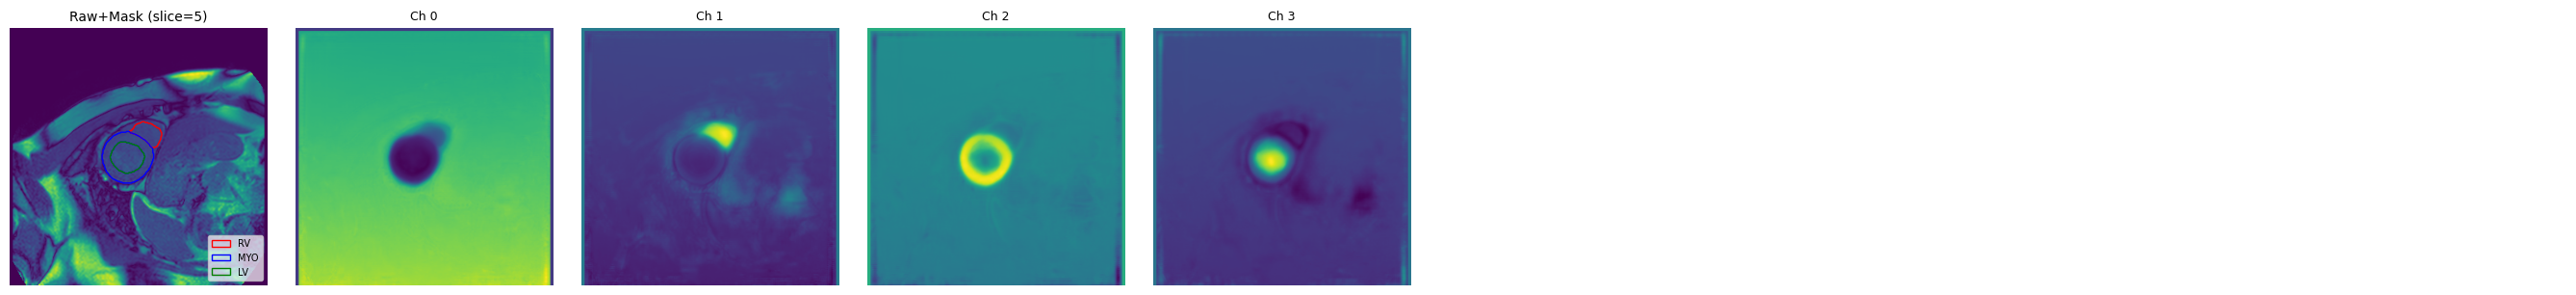

In [94]:
# 选第 0 个 frame 的 feature
feat_path = os.path.join(results_folder, npz_files[2])

# 看 enc_stage0 这一层，第 0 个 slice，上面前 16 个 channel
visualize_layer_with_raw(
    npz_path=feat_path,
    layer_key="logits_stage5",   # 改这个可以看 enc_stage1/2/...、dec_stage0/...、logits_final
    slice_idx=5,              # 体数据时就是第几个 z-slice；2D 的话就无所谓
    max_channels=32,          # 一次看多少个 channel
    cmap="viridis"
)

In [19]:
# 打印每一层的shape和所占空间，做成表格
import pandas as pd

npz_file = npz_files[0]
feat_file = np.load(os.path.join(results_folder, npz_file))

layer_info = []
for key in feat_file.keys():
    arr = feat_file[key]
    layer_info.append({
        "Layer": key,
        "Shape": arr.shape,
        "Size (MB)": arr.nbytes / 1024**2
    })

df = pd.DataFrame(layer_info)
print(f"Feature file: {npz_file}")
print(df.to_string(index=False))


Feature file: 0001_0_features.npz
        Layer               Shape  Size (MB)
 logits_final   (4, 11, 320, 320)    8.59375
   dec_stage0 (480, 11, 320, 320) 1031.25000
   dec_stage1 (480, 11, 320, 320) 1031.25000
   dec_stage2 (256, 11, 320, 320)  550.00000
   dec_stage3 (128, 11, 320, 320)  275.00000
   dec_stage4  (64, 11, 320, 320)  137.50000
   dec_stage5  (32, 11, 320, 320)   68.75000
   enc_stage0  (32, 11, 320, 320)   68.75000
   enc_stage1  (64, 11, 320, 320)  137.50000
   enc_stage2 (128, 11, 320, 320)  275.00000
   enc_stage3 (256, 11, 320, 320)  550.00000
   enc_stage4 (480, 11, 320, 320) 1031.25000
   enc_stage5 (480, 11, 320, 320) 1031.25000
logits_stage0   (4, 11, 320, 320)    8.59375
logits_stage1   (4, 11, 320, 320)    8.59375
logits_stage2   (4, 11, 320, 320)    8.59375
logits_stage3   (4, 11, 320, 320)    8.59375
logits_stage4   (4, 11, 320, 320)    8.59375
logits_stage5   (4, 11, 320, 320)    8.59375


raw_vol.shape = (320, 320, 11)
Assume slice dim = 2
INFO: transposed raw (and seg) for visualization.


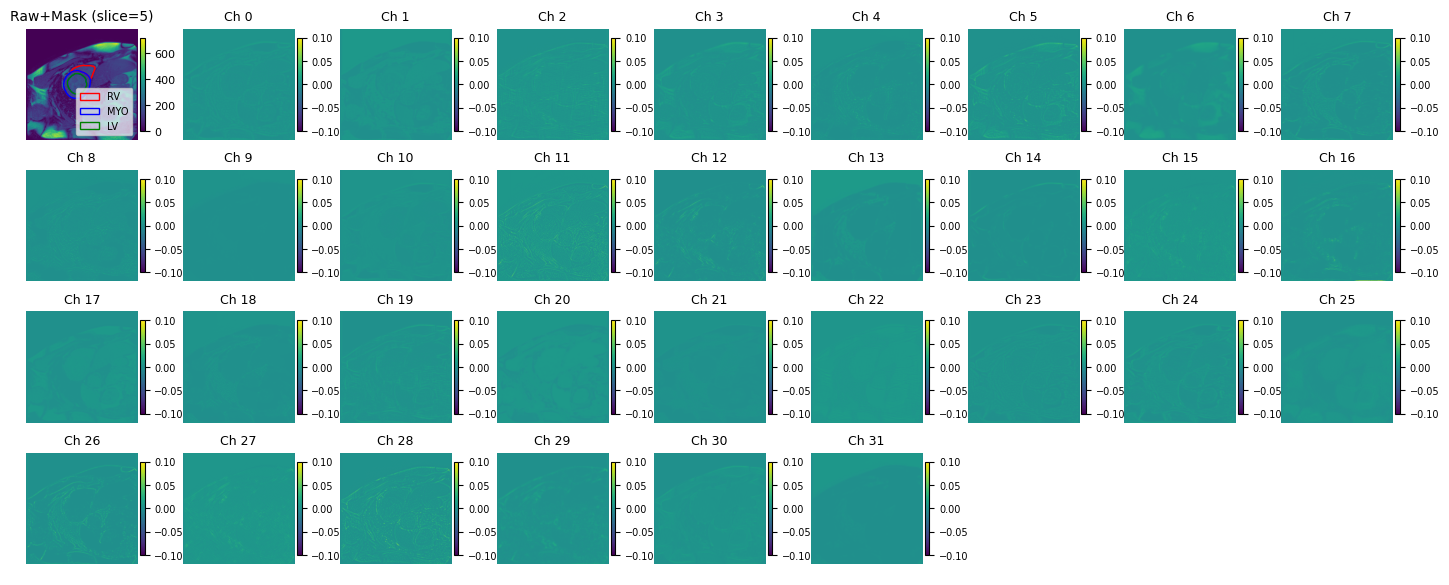

In [34]:
# now I want to visualize the feature map layer by layer, for channels > 32, just show the first 32
# 选第 0 个 frame 的 feature
feat_path = os.path.join(results_folder, npz_files[4])

# 看 enc_stage0 这一层，第 0 个 slice，上面前 16 个 channel
visualize_layer_with_raw(
    npz_path=feat_path,
    layer_key="enc_stage0",   # 改这个可以看 enc_stage1/2/...、dec_stage0/...、logits_final
    slice_idx=5,              # 体数据时就是第几个 z-slice；2D 的话就无所谓
    max_channels=32,          # 一次看多少个 channel
    cmap="viridis"
)

In [90]:
def visualize_feature_map_across_slices(
    npz_path: str, layer_key: str, max_slices: int = 16, max_channels: int = 8, cmap: str = "viridis"
):
    """
    可视化某一层在不同 slice 上的 feature map。展示前 max_slices 个 slices，每个 slice 展示前 max_channels 个 channel。
    第一列为原图（raw image）。
    """
    feat_file = np.load(npz_path)
    raw_vol, _ = load_raw_image_for_npz(npz_path)
    if layer_key not in feat_file:
        raise KeyError(f"{layer_key} not in {list(feat_file.keys())}")
    arr = feat_file[layer_key]

    if arr.ndim == 4:
        # (C, Z, H, W) or (Z, C, H, W)
        shape = arr.shape
        if shape[0] <= 32 and shape[1] > 8:
            # Assume (C, Z, H, W)
            ch_axis, z_axis = 0, 1
        else:
            # Assume (Z, C, H, W)
            z_axis, ch_axis = 0, 1
        num_slices = arr.shape[z_axis]
        num_channels = arr.shape[ch_axis]

        n_slices_show = min(num_slices, max_slices)
        n_channels_show = min(num_channels, max_channels)

        # 第一列预留出来显示原图
        fig, axes = plt.subplots(
            n_slices_show, n_channels_show + 1,
            figsize=((n_channels_show + 1) * 4, n_slices_show * 4)
        )
        # 直接 (H,W,C) 和 (C,H,W) 都不管，统统转成 (H,W,C) 然后按 [slice] axis plot
        for y in range(n_slices_show):
            ax = axes[y, 0]
            if raw_vol.ndim == 3 and raw_vol.shape[0] == num_slices:
                # (Z,H,W) or (Z,H,W,1/3)
                img = raw_vol[y]
            else:
                # 不是 3d 的，直接原图
                img = raw_vol

            # 转一下，保证 (H,W,C)
            if img.ndim == 3:
                img = np.transpose(img, (2,1,0))
            ax.imshow(img[y], cmap="gray" if img.ndim==2 else None)
            ax.set_title(f"Raw Slice {y}")
            ax.axis("off")

        # 填主区域（feature map）
        for y in range(n_slices_show):
            for x in range(n_channels_show):
                if shape[0] <= 32 and shape[1] > 8:
                    # (C,Z,H,W)
                    img = arr[x, y]
                else:
                    # (Z,C,H,W)
                    img = arr[y, x]
                ax = axes[y, x + 1]
                ax.imshow(img, cmap=cmap)
                ax.set_title(f"Slice {y}, Ch {x}")
                ax.axis("off")

        plt.tight_layout()
        plt.show()
    elif arr.ndim == 3:
        print(f"Layer {layer_key} does not have a slice axis, only {arr.shape}")
    else:
        print(f"Unsupported feature shape {arr.shape} for layer {layer_key}")


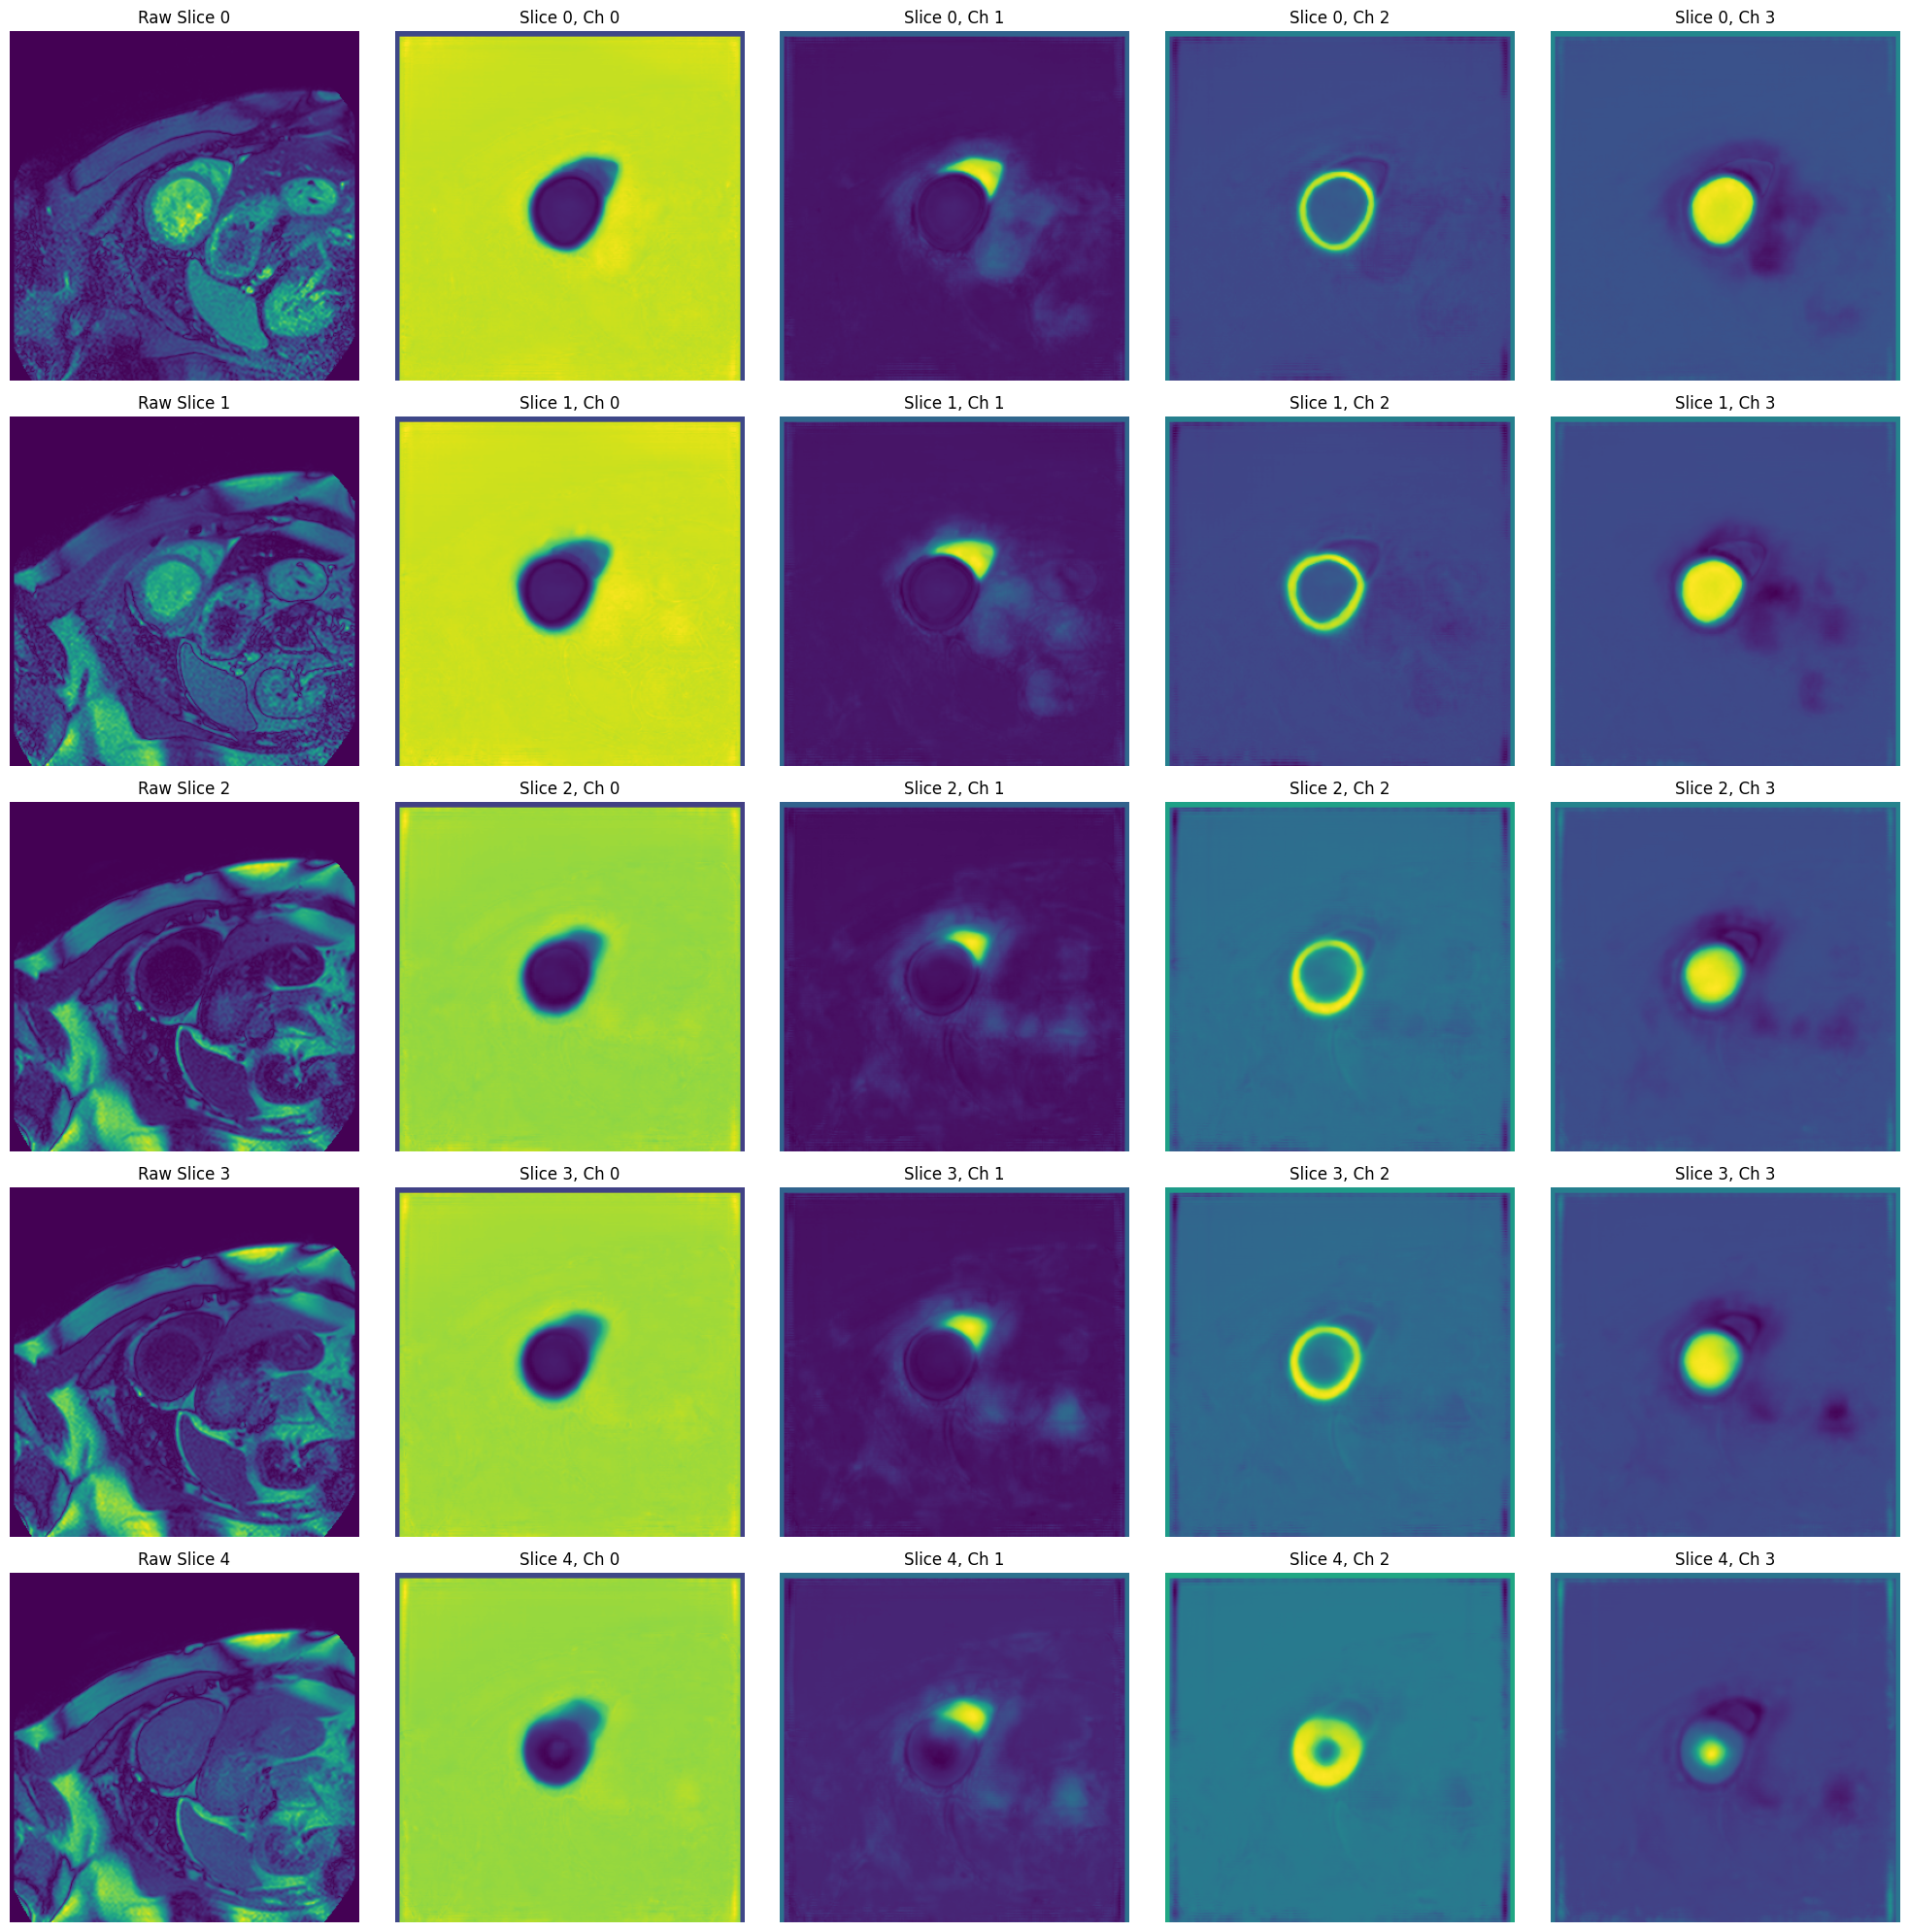

In [93]:
visualize_feature_map_across_slices(
    npz_path=feat_path,
    layer_key="logits_final",
    max_slices=5,
    max_channels=8,
    cmap="viridis"
)

raw_vol.shape = (320, 320, 11)
Assume slice dim = 2
INFO: transposed raw (and seg) for visualization.


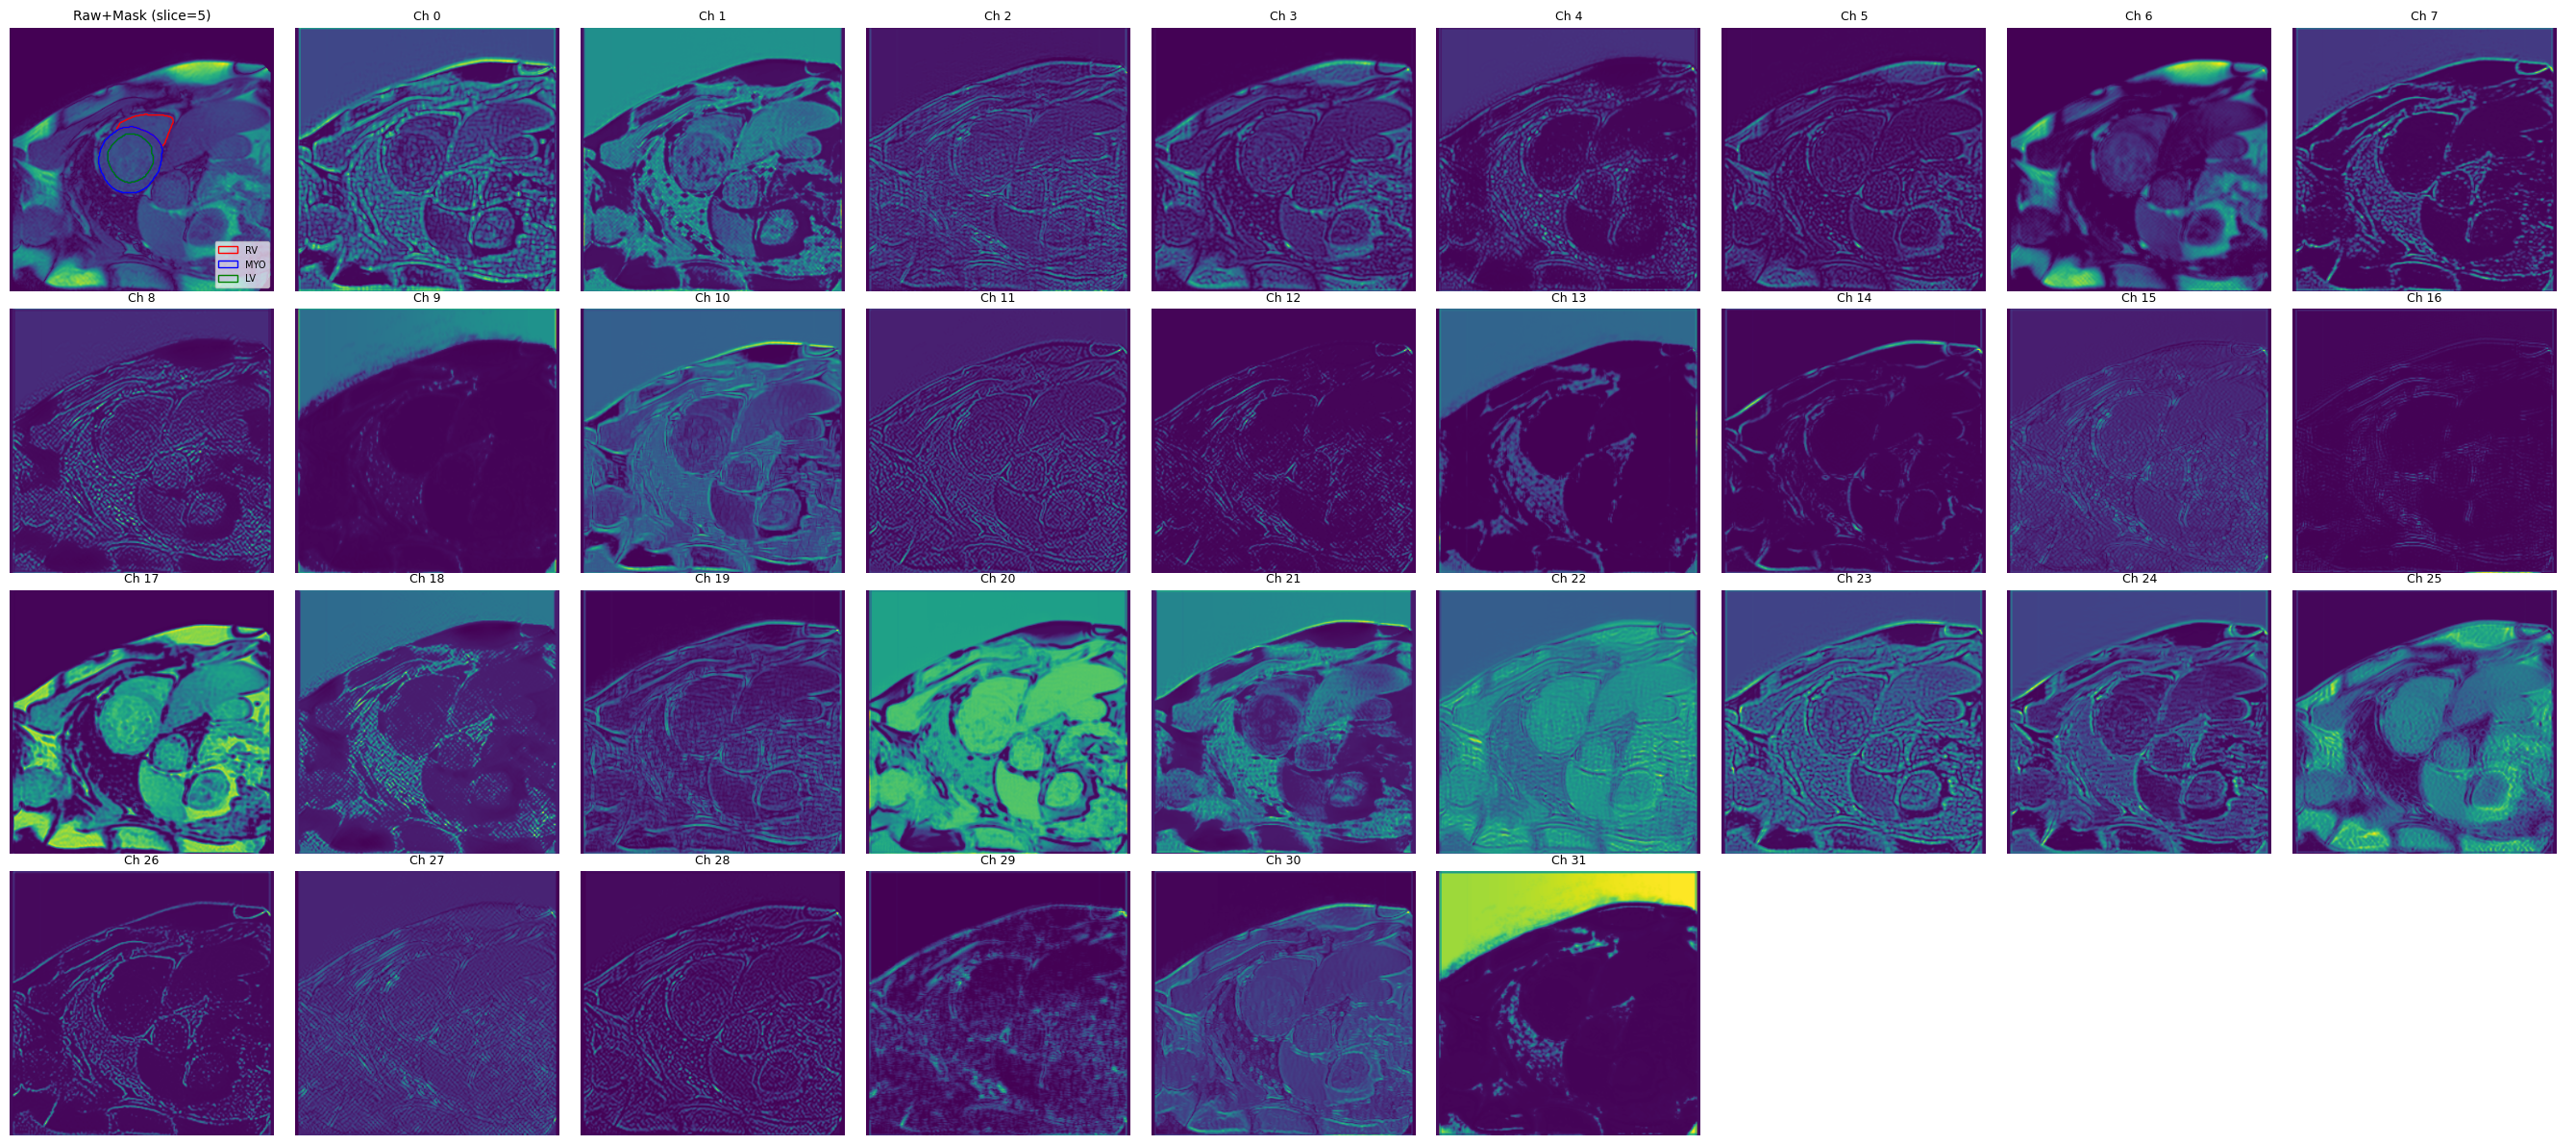